In [4]:
# !pip install -r requirements.txt

In [217]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')
import pickle
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/giorgiomondauto/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/giorgiomondauto/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/giorgiomondauto/nltk_data...
[nltk_data]   Package words is already up-to-date!


### Load the data

In [218]:
professioni = pd.read_csv('data/professioni.csv')
dati_aprile = pd.read_csv('Job_vacancies_aprile_completo.csv', skiprows=1, usecols = [1,2,3],\
                          names = ['Target','Sub_Role','Job_Description'])
print('dati_aprile shape {}'.format(dati_aprile.shape))
dati_aprile.head()

dati_aprile shape (650, 3)


,Target,Sub_Role,Job_Description
0,Elettromeccanici,Manutentore elettromeccanico,Randstad Technical di Vimercate seleziona un m...
1,Elettromeccanici,Manutentore elettromeccanico,"Quanta SpA, Filiale di Verona, seleziona per a..."
2,Elettromeccanici,Tecnico elettromeccanico,"Kelly Services, multinazionale americana leade..."
3,Elettromeccanici,Manutentore elettromeccanico,"Lavoropiù Everywhere, la divisione di Lavoropi..."
4,Elettromeccanici,AGGIUSTATORE MECCANICO,Randstad Italia filiale di Foligno ricerca per...


In [219]:
dati_aprile.Target.value_counts()

Commessi delle vendite al minuto    149
Statistici                          104
Camerieri di ristorante             100
Cuochi in alberghi e ristoranti     100
Elettromeccanici                     99
Tecnici web                          98
Name: Target, dtype: int64

In [220]:
print('Professioni')
professioni.head()

Professioni


,Group,Subgroup,Descrizione_professione,Descrizione_professione2,subgroup1,subgroup2,Esco_Abilit_compet_essenz,Esco_conoscenze_essenz,Esco_Abilit_compet_opz,Conoscenze
0,Statistici,Attuario\nData scientist\nEsperto in ricerca o...,Accertamenti tecnici per la valutazione delle ...,Elaborare piani tecnici per la trasformazione ...,consulente attuariale\ndemografo demografa\nsp...,consulente attuariale\ndemografo demografa\nsp...,correggere i dati\ncostruire sistemi di raccom...,classificazione delle informazioni\nelaborazio...,creare modelli di dati\ndefinire criteri di qu...,LDAP\nLINQ\nMDX\nN1QL\nSPARQL\nXQuery\nbusines...
1,Cuochi in alberghi e ristoranti,Aiuto cuoco\nAiuto cuoco di ristorante\nAntipa...,Allestimento dei piatti\nApplicazione delle pr...,Effettuare la preparazione dell'impasto da piz...,capo chef pasticcere capo chef pasticcera\nche...,addetta alla preparazione degli alimenti\ncuoc...,consegnare la zona di preparazione di alimenti...,"legislazione in materia di salute, sicurezza e...",NaN,NaN
2,Commessi alle vendite al minuto,Addetto al banco vendita di macelleria\nAddett...,Allestimento degli scaffali e delle isole prom...,Allestire e rifornire gli scaffali e le isole ...,commesso di negozio di abbigliamento commessa ...,commessa di negozio di abbigliamento uomo donn...,applicare le competenze matematiche\nconsiglia...,argomentazione di vendita\ncaratteristiche dei...,eseguire piccoli interventi di sartoria,industria dell'abbigliamento
3,Elettromeccanici,Aggiustatore elettromeccanico\nAvvolgitore di ...,Cablatura dell'impianto elettrico\nCollaudo de...,Effettuare la diagnosi tecnica (strumentale e ...,manutentore elettromeccanico manutentrice elet...,elettricista a bordo macchina\nelettricista-me...,adattare le attrezzature meccanizzate\napplica...,elettricità\nelettromeccanica\nelettronica\nme...,applicare un rivestimento alle apparecchiature...,accessori per cavi elettrici\ncomponenti di ba...


### Text Preprocessing on Professioni csv

In [221]:
professioni.Subgroup = professioni.Subgroup.apply(lambda x: x.lower().split('\n'))
professioni.subgroup1 = professioni.subgroup1.apply(lambda x: x.lower().split('\n'))
professioni.subgroup2 = professioni.subgroup2.apply(lambda x: x.lower().split('\n'))
professioni.Subgroup = professioni.Subgroup + professioni.subgroup1 + professioni.subgroup2
professioni.Subgroup = professioni.Subgroup.apply(lambda x: list(set(x)))

In [222]:
professioni.head()

,Group,Subgroup,Descrizione_professione,Descrizione_professione2,subgroup1,subgroup2,Esco_Abilit_compet_essenz,Esco_conoscenze_essenz,Esco_Abilit_compet_opz,Conoscenze
0,Statistici,"[, demografo demografa, data scientist, specia...",Accertamenti tecnici per la valutazione delle ...,Elaborare piani tecnici per la trasformazione ...,"[consulente attuariale, demografo demografa, s...","[consulente attuariale, demografo demografa, s...",correggere i dati\ncostruire sistemi di raccom...,classificazione delle informazioni\nelaborazio...,creare modelli di dati\ndefinire criteri di qu...,LDAP\nLINQ\nMDX\nN1QL\nSPARQL\nXQuery\nbusines...
1,Cuochi in alberghi e ristoranti,"[, cuoco di albergo, cuoco di ristorante, past...",Allestimento dei piatti\nApplicazione delle pr...,Effettuare la preparazione dell'impasto da piz...,"[capo chef pasticcere capo chef pasticcera, ch...","[addetta alla preparazione degli alimenti, cuo...",consegnare la zona di preparazione di alimenti...,"legislazione in materia di salute, sicurezza e...",NaN,NaN
2,Commessi alle vendite al minuto,"[, pratico di farmacia, commessa di negozio di...",Allestimento degli scaffali e delle isole prom...,Allestire e rifornire gli scaffali e le isole ...,[commesso di negozio di abbigliamento commessa...,[commessa di negozio di abbigliamento uomo don...,applicare le competenze matematiche\nconsiglia...,argomentazione di vendita\ncaratteristiche dei...,eseguire piccoli interventi di sartoria,industria dell'abbigliamento
3,Elettromeccanici,"[, elettromeccanico, installatore di impianti ...",Cablatura dell'impianto elettrico\nCollaudo de...,Effettuare la diagnosi tecnica (strumentale e ...,[manutentore elettromeccanico manutentrice ele...,"[elettricista a bordo macchina, elettricista-m...",adattare le attrezzature meccanizzate\napplica...,elettricità\nelettromeccanica\nelettronica\nme...,applicare un rivestimento alle apparecchiature...,accessori per cavi elettrici\ncomponenti di ba...


### Create a dictionary for professioni. e.g. 
{Statistici : ['attuario', 'data scientist', 'esperto in ricerca operativa',..... ]}

In [130]:
professioni_dictionary = pd.Series(professioni.Subgroup.values,index=professioni.Group).to_dict()
# to remove empty space from the subgroup list of values
for i in range(0,professioni.Subgroup.shape[0]):
    while("" in professioni.Subgroup.iloc[i]) : 
        professioni.Subgroup.iloc[i].remove("") 

In [131]:
professioni_dictionary

{'Statistici': ['demografo demografa',
  'data scientist',
  'specialista in biometria',
  'consulente attuariale',
  'esperto ricerca operativa',
  'attuario',
  'esperto in ricerca operativa',
  'statistico economico',
  'statistico metodologico',
  'statistico',
  'statistici',
  'statistico statistica',
  'statistico applicato',
  'statistico esperto in controlli di qualità'],
 'Cuochi in alberghi e ristoranti': ['cuoco di albergo',
  'cuoco di ristorante',
  'pasticcere',
  'capo chef pasticcera',
  'chef privata',
  'capo chef pasticcere capo chef pasticcera',
  'grigliere',
  'cuoco capo partita',
  ' cuoco gelatiere',
  'cuoco di partita di zuppe',
  'capo pasticcere',
  'antipastiere',
  'cuoco pasticciere',
  'grigliera',
  'cuoco cuoca',
  'chef privato',
  'cuoco antipastiere',
  'cuoco addetto alla griglia',
  'cuoca esperta in pesce',
  'chef privato chef privata',
  'aiuto cuoco',
  'cuoco in dietetica',
  'cuoco di partita di camera fredda',
  ' salsiere',
  'cuoca',
  

In [132]:
# I need this step to convert back
subgroup_dict = {}
for group, subgroups in professioni_dictionary.items():
    for subgroup in subgroups:
        subgroup_dict[subgroup] = group
subgroup_dict

{'demografo demografa': 'Statistici',
 'data scientist': 'Statistici',
 'specialista in biometria': 'Statistici',
 'consulente attuariale': 'Statistici',
 'esperto ricerca operativa': 'Statistici',
 'attuario': 'Statistici',
 'esperto in ricerca operativa': 'Statistici',
 'statistico economico': 'Statistici',
 'statistico metodologico': 'Statistici',
 'statistico': 'Statistici',
 'statistici': 'Statistici',
 'statistico statistica': 'Statistici',
 'statistico applicato': 'Statistici',
 'statistico esperto in controlli di qualità': 'Statistici',
 'cuoco di albergo': 'Cuochi in alberghi e ristoranti',
 'cuoco di ristorante': 'Cuochi in alberghi e ristoranti',
 'pasticcere': 'Cuochi in alberghi e ristoranti',
 'capo chef pasticcera': 'Cuochi in alberghi e ristoranti',
 'chef privata': 'Cuochi in alberghi e ristoranti',
 'capo chef pasticcere capo chef pasticcera': 'Cuochi in alberghi e ristoranti',
 'grigliere': 'Cuochi in alberghi e ristoranti',
 'cuoco capo partita': 'Cuochi in alberghi

### Text Preprocessing on Job Descripion column

#### Tokenization
split the text into words

In [133]:
# remove punctuation
dati_aprile.Job_Description = dati_aprile.Job_Description.apply(lambda x: re.sub('[^a-zA-Z]',' ',x))
dati_aprile.Target = dati_aprile.Target.apply(lambda x: x.lower())
dati_aprile.Job_Description = dati_aprile['Job_Description'].apply(lambda x: word_tokenize(x.lower())) # lowercase each word
dati_aprile.head()

,Target,Sub_Role,Job_Description
0,elettromeccanici,Manutentore elettromeccanico,"[randstad, technical, di, vimercate, seleziona..."
1,elettromeccanici,Manutentore elettromeccanico,"[quanta, spa, filiale, di, verona, seleziona, ..."
2,elettromeccanici,Tecnico elettromeccanico,"[kelly, services, multinazionale, americana, l..."
3,elettromeccanici,Manutentore elettromeccanico,"[lavoropi, everywhere, la, divisione, di, lavo..."
4,elettromeccanici,AGGIUSTATORE MECCANICO,"[randstad, italia, filiale, di, foligno, ricer..."


remove words with lenght < 3 (e.g. numbers and not meaningful words)

In [134]:
dati_aprile.Job_Description = dati_aprile.Job_Description.apply(lambda x: [i for i in x if len(i) >3])
dati_aprile.Job_Description.head() # note the word 'vimercate' in row = 0

0    [randstad, technical, vimercate, seleziona, ma...
1    [quanta, filiale, verona, seleziona, azienda, ...
2    [kelly, services, multinazionale, americana, l...
3    [lavoropi, everywhere, divisione, lavoropi, sp...
4    [randstad, italia, filiale, foligno, ricerca, ...
Name: Job_Description, dtype: object

In [135]:
##### remove in 'job_description' words from 'fonte'
Fonti = ['randstad', 'monster', 'infojob', 'technical', 'kelly', 'services', 'italia', 'lavoropi','quanta']
dati_aprile.Job_Description = dati_aprile.Job_Description.apply(lambda x: [i for i in x if i not in Fonti])
dati_aprile.Job_Description.head(5) # compare row 0 and row 2 with previous row 0 and row 2

0    [vimercate, seleziona, manutentore, inseriment...
1    [filiale, verona, seleziona, azienda, cliente,...
2    [multinazionale, americana, leader, nelle, ris...
3    [everywhere, divisione, specializzata, nella, ...
4    [filiale, foligno, ricerca, importante, aziend...
Name: Job_Description, dtype: object

#### Stopwords
Stopwords are words generally not relevant to a text; thereby we get rid of them

In [136]:
list_stopwords = list(set(stopwords.words('italian')))
print('Example of stopwords:',list_stopwords[:20])
print(10 * '%')
print('lenth of stopwords: {}'.format(len(list_stopwords)))
# molte sono state tagliate nel passaggio precedente when i len < 4

Example of stopwords: ['sul', 'quella', 'dagl', 'gli', 'col', 'del', 'avevate', 'anche', 'tu', 'farai', 'facendo', 'stiate', 'nell', 'stessi', 'saranno', 'vostra', 'sulle', 'perché', 'lei', 'dal']
%%%%%%%%%%
lenth of stopwords: 279


In [137]:
dati_aprile.Job_Description = dati_aprile.Job_Description.apply(lambda x: [i for i in x if i not in list_stopwords] )
dati_aprile.Job_Description.head(5)

0    [vimercate, seleziona, manutentore, inseriment...
1    [filiale, verona, seleziona, azienda, cliente,...
2    [multinazionale, americana, leader, risorse, u...
3    [everywhere, divisione, specializzata, ricerca...
4    [filiale, foligno, ricerca, importante, aziend...
Name: Job_Description, dtype: object

In [138]:
# wordcloud of main words
def cloud(data,backgroundcolor = 'white', width = 800, height = 600):
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color = backgroundcolor,
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

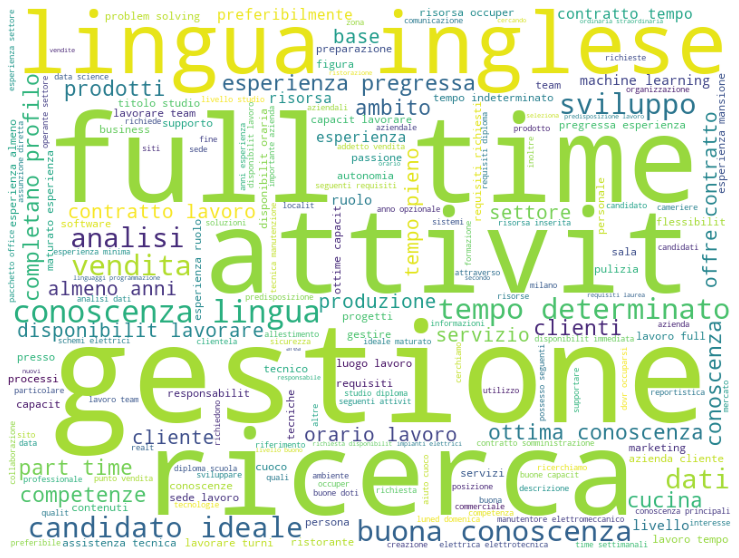

In [139]:
job_description = dati_aprile['Job_Description'].apply(lambda x: ' '.join(x))
cloud(' '.join(job_description)) # most common words

#### Remove words referring to: Comuni, Provincie, Regioni

In [140]:
# load a text file containing a list of 'Comuni, Provincie, Regioni' italiane
geo_data = pd.read_fwf('data/listacomuni.txt')
geo_data.to_csv('data/listacomuni.csv')
geo_data = pd.read_csv('data/listacomuni.csv', sep=';')
comune = [i.lower() for i in geo_data.Comune]
geo_data.Provincia = geo_data.Provincia.apply(lambda x: str(x))
provincia = [i.lower() for i in geo_data.Provincia]
regione = [i.lower() for i in geo_data.Regione]
print('Comuni samples:',comune[:10])
print(20*'%')
print('Provincia samples:',provincia[:10])
print(20*'%')
print('Regione samples:',regione[:10])

Comuni samples: ['abano terme', 'abbadia cerreto', 'abbadia lariana', 'abbadia san salvatore', 'abbasanta', 'abbateggio', 'abbiategrasso', 'abetone', 'abriola', 'acate']
%%%%%%%%%%%%%%%%%%%%
Provincia samples: ['pd', 'lo', 'lc', 'si', 'or', 'pe', 'mi', 'pt', 'pz', 'rg']
%%%%%%%%%%%%%%%%%%%%
Regione samples: ['ven', 'lom', 'lom', 'tos', 'sar', 'abr', 'lom', 'tos', 'bas', 'sic']


In [141]:
def remove_comuni(data, column, geo_data):
    ''' function to remove geographic noisy'''
    comune = [i.lower() for i in geo_data.Comune]
    geo_data.Provincia = geo_data.Provincia.apply(lambda x: str(x))
    provincia = [i.lower() for i in geo_data.Provincia]
    regione = [i.lower() for i in geo_data.Regione]
    
    data[column] = data[column].apply(lambda x: [i for i in x if i not in comune])
    data[column] = data[column].apply(lambda x: [i for i in x if i not in provincia])
    data[column] = data[column].apply(lambda x: [i for i in x if i not in regione])
    
    return data

In [142]:
dati_aprile = remove_comuni(dati_aprile, 'Job_Description', geo_data)
dati_aprile.head(5)

,Target,Sub_Role,Job_Description
0,elettromeccanici,Manutentore elettromeccanico,"[seleziona, manutentore, inserimento, somminis..."
1,elettromeccanici,Manutentore elettromeccanico,"[filiale, seleziona, azienda, cliente, settore..."
2,elettromeccanici,Tecnico elettromeccanico,"[multinazionale, americana, leader, risorse, u..."
3,elettromeccanici,Manutentore elettromeccanico,"[everywhere, divisione, specializzata, ricerca..."
4,elettromeccanici,AGGIUSTATORE MECCANICO,"[filiale, ricerca, importante, azienda, client..."


##### Get rid of unusual_words : misspelled words - uncommon words¶

In [143]:
italian_vocab = pd.read_fwf('data/660000_parole_italiane.txt', names = ['word'])
italian_vocab = set(italian_vocab.word.tolist())
english_vocab = sorted(set(w.lower() for w in nltk.corpus.words.words())) # english vocabulary

In [144]:
def uncommon_words(data,column, italian_vocab, english_vocab = None):
    data[column] = data[column].apply(lambda x: [i for i in x if i in italian_vocab])
    return data

In [145]:
dati_aprile = uncommon_words(dati_aprile, 'Job_Description', italian_vocab, english_vocab)
dati_aprile # note that the word 'vimercate' is not present anymore

,Target,Sub_Role,Job_Description
0,elettromeccanici,Manutentore elettromeccanico,"[seleziona, manutentore, inserimento, presso, ..."
1,elettromeccanici,Manutentore elettromeccanico,"[filiale, seleziona, azienda, cliente, settore..."
2,elettromeccanici,Tecnico elettromeccanico,"[multinazionale, americana, leader, risorse, u..."
3,elettromeccanici,Manutentore elettromeccanico,"[divisione, specializzata, ricerca, selezione,..."
4,elettromeccanici,AGGIUSTATORE MECCANICO,"[filiale, ricerca, importante, azienda, client..."
...,...,...,...
645,commessi delle vendite al minuto,addetto alla vendita specializzato in cosmesi ...,"[proprietaria, marchio, profumerie, ricerca, a..."
646,commessi delle vendite al minuto,addetto alla vendita specializzato in cosmesi ...,"[punto, vendita, insegna, beauty, star, ricerc..."
647,commessi delle vendite al minuto,addetto alla vendita nel settore tessile,"[filiale, ricerca, addetto, vendita, inserire,..."
648,commessi delle vendite al minuto,addetto alla vendita nel settore tessile,"[risorse, dovranno, svolgere, attivita, vendit..."


                  Frequency
ELETTROMECCANICI           
manutenzione            179
impianti                151
esperienza              133
elettrici               103
conoscenza              100
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                 Frequency
CUOCHI IN ALBERGHI E RISTORANTI           
lavoro                                 105
cuoco                                   96
esperienza                              95
cucina                                  91
contratto                               69
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
            Frequency
STATISTICI           
conoscenza        237
data              233
dati              176
analisi           157
esperienza        131
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
             Frequency
TECNICI WEB           


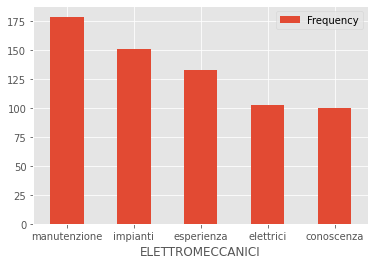

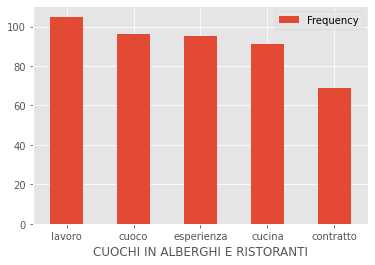

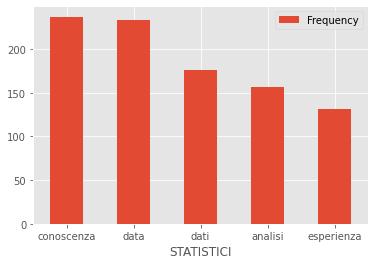

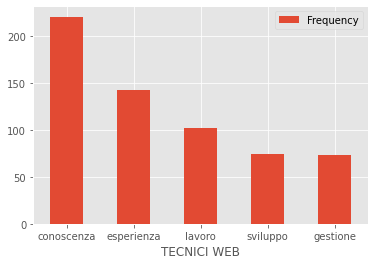

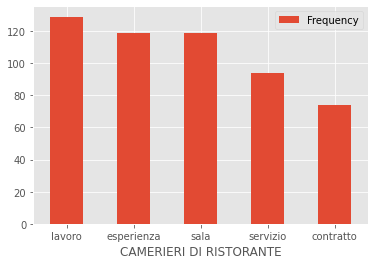

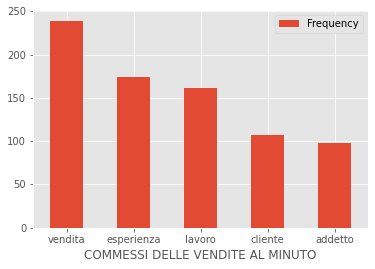

In [146]:
%matplotlib inline
matplotlib.style.use('ggplot')
field = "Job_Description"
Role = list(dati_aprile.Target.unique())
for i in Role:
    txt = dati_aprile[dati_aprile['Target']==i][field]
    txt = [i for x in txt.tolist() for i in x]
    words_except_stop_dist = nltk.FreqDist(w for w in txt) 
    words_except_stop_dist
    rslt = pd.DataFrame(words_except_stop_dist.most_common(5),
                            columns=[i.upper(), 'Frequency']).set_index(i.upper())
    print(rslt)
    matplotlib.style.use('ggplot')
    rslt.plot.bar(rot=0)
    print(100 *'%')

##### Create Role dictionary and encode the column Role

In [147]:
Role_dictionary = pd.Series(dati_aprile['Target'].unique()).to_dict()
Role_dictionary = dict([(value, key) for key, value in Role_dictionary.items()])
Role_dictionary

{'elettromeccanici': 0,
 'cuochi in alberghi e ristoranti': 1,
 'statistici': 2,
 'tecnici web': 3,
 'camerieri di ristorante': 4,
 'commessi delle vendite al minuto': 5}

In [148]:
role_encoded = []
for i in dati_aprile.Target:
    role_encoded.append(Role_dictionary.get(i, None))

In [149]:
##### replace old role values with new values
dati_aprile['Multi_Class'] = role_encoded
dati_aprile.head()

,Target,Sub_Role,Job_Description,Multi_Class
0,elettromeccanici,Manutentore elettromeccanico,"[seleziona, manutentore, inserimento, presso, ...",0
1,elettromeccanici,Manutentore elettromeccanico,"[filiale, seleziona, azienda, cliente, settore...",0
2,elettromeccanici,Tecnico elettromeccanico,"[multinazionale, americana, leader, risorse, u...",0
3,elettromeccanici,Manutentore elettromeccanico,"[divisione, specializzata, ricerca, selezione,...",0
4,elettromeccanici,AGGIUSTATORE MECCANICO,"[filiale, ricerca, importante, azienda, client...",0


In [150]:
dati_aprile['Multi_Class'].value_counts()

5    149
2    104
4    100
1    100
0     99
3     98
Name: Multi_Class, dtype: int64

In [151]:
dati_aprile['Target'].value_counts()

commessi delle vendite al minuto    149
statistici                          104
cuochi in alberghi e ristoranti     100
camerieri di ristorante             100
elettromeccanici                     99
tecnici web                          98
Name: Target, dtype: int64

#### Have a look at bigrams

In [152]:
from nltk import bigrams, collocations
Text = dati_aprile.Job_Description.iloc[1]
bigrams_from_text = bigrams(Text)
list(bigrams_from_text)[:6]

[('filiale', 'seleziona'),
 ('seleziona', 'azienda'),
 ('azienda', 'cliente'),
 ('cliente', 'settore'),
 ('settore', 'metalmeccanico'),
 ('metalmeccanico', 'manutentore')]

In [153]:
bigrams_from_text = bigrams(Text)
list(iter(dict(nltk.FreqDist(i for i in list(bigrams_from_text))).items()))[:6]

[(('filiale', 'seleziona'), 1),
 (('seleziona', 'azienda'), 1),
 (('azienda', 'cliente'), 1),
 (('cliente', 'settore'), 1),
 (('settore', 'metalmeccanico'), 1),
 (('metalmeccanico', 'manutentore'), 1)]

In [154]:
dati_aprile.Job_Description = dati_aprile.Job_Description.apply(lambda x: ' '.join(x))
dati_aprile.Job_Description.head()

0    seleziona manutentore inserimento presso azien...
1    filiale seleziona azienda cliente settore meta...
2    multinazionale americana leader risorse umane ...
3    divisione specializzata ricerca selezione prof...
4    filiale ricerca importante azienda cliente agg...
Name: Job_Description, dtype: object

### Data Split

In [209]:
X_train, X_test, y_train, y_test = train_test_split(dati_aprile['Job_Description'], 
                                                    dati_aprile['Multi_Class'],
                                                   test_size=0.20, random_state=42)

print('Number of rows in the total set: {}'.format(dati_aprile.shape[0]))
print('Number of rows in the training set: {}'.format(X_train.shape[0]))
print('Number of rows in the test set: {}'.format(X_test.shape[0]))

Number of rows in the total set: 650
Number of rows in the training set: 520
Number of rows in the test set: 130


### Bag of Words processing to our dataset

In [210]:
from sklearn.feature_extraction.text import CountVectorizer
count_vector = CountVectorizer()

# Fit the training data and then return the matrix
training_data = count_vector.fit_transform(X_train)

# Transform testing data and return the matrix. Note we are not fitting the testing data into the CountVectorizer()
testing_data = count_vector.transform(X_test)

In [211]:
training_data.toarray().shape

(520, 4182)

In [212]:
print('training data',training_data.shape)
print('testing data',testing_data.shape)

training data (520, 4182)
testing data (130, 4182)


### Naive Bayes implementation

In [213]:
naive_bayes = MultinomialNB()
naive_bayes.fit(training_data, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [214]:
def get_key(value, dictionary):
    for k,v in dictionary.items():
        if value == v:
            return k

In [215]:
predictions = naive_bayes.predict(testing_data)
predictions_keys = []
for i in predictions:
    predictions_keys.append(get_key(i,Role_dictionary))
print('Prediction for rows {} are \n {}'.format(X_test.index.tolist()[:10],predictions_keys[:10]))

print(100*'%')
actual_predictions = []
for i in y_test.tolist():
    actual_predictions.append(get_key(i,Role_dictionary))
print('actual predictions are: \n {}'.format(actual_predictions[:10]))

Prediction for rows [637, 220, 428, 326, 72, 516, 181, 131, 231, 277] are 
 ['commessi delle vendite al minuto', 'statistici', 'camerieri di ristorante', 'tecnici web', 'elettromeccanici', 'commessi delle vendite al minuto', 'cuochi in alberghi e ristoranti', 'cuochi in alberghi e ristoranti', 'statistici', 'statistici']
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
actual predictions are: 
 ['commessi delle vendite al minuto', 'statistici', 'camerieri di ristorante', 'tecnici web', 'elettromeccanici', 'commessi delle vendite al minuto', 'cuochi in alberghi e ristoranti', 'cuochi in alberghi e ristoranti', 'statistici', 'statistici']


In [216]:
# check the accuracy of our model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Accuracy score: ', format(accuracy_score(y_test,predictions)))

Accuracy score:  0.9692307692307692


In [229]:
actual_predictions[:5]

['commessi delle vendite al minuto',
 'statistici',
 'camerieri di ristorante',
 'tecnici web',
 'elettromeccanici']

In [230]:
X_test.iloc[:5]

637    addetto banco panetteria pasticceria sede lavo...
220    cercando data esperto appassionato unisca team...
428    hotel ristorante zona nord ricerca cameriere p...
326    full programmazione orienta agenzia lavoro esp...
72     azienda metalmeccanica zona ricerca cablatore ...
Name: Job_Description, dtype: object